In [69]:
%matplotlib notebook

import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np

# Question: Is change of the religiousness of US population correlated with violent events, such as mass shootings?
For some time people been bothering themselves with question: does religiousness lead to peace as a part of some enlightment, or does it lead to violence, as a consequence of segregation of 'us' and 'them'?
In this little study I'll try to answer this question on the scale of the modern US statistics.

### Getting data ready

In [71]:
# dataset from http://www.thearda.com/Archive/Files/Downloads/WRDNATL_DL2.asp
rdf = pd.read_excel("data1.xlsx")

In [72]:
rdf = rdf[rdf['ISO3'] == 'USA']
rdf = rdf[['YEAR', 'NONRELIG', 'POP']]
rdf['YEAR'] = rdf['YEAR'].astype(int)
rdf['NONRELIG'] = rdf['NONRELIG'].apply(lambda x: x.replace(',','')).astype(int)
rdf['POP'] = rdf['POP'].apply(lambda x: x.replace(',','')).astype(int)
# we have to calculate the amount of religious people that way, because the sum of all religious people
# would get us incorrect number, for some people have several religions at once
rdf['RELIG'] = rdf['POP'] - rdf['NONRELIG'] 

In [73]:
# data from https://www.kaggle.com/zusmani/us-mass-shootings-last-50-years/data
sdf = pd.read_csv("data2.csv", encoding = "ISO-8859-1", parse_dates=["Date"])

In [74]:
sdf['Date'] = sdf.apply(lambda x: str(x['Date']).split('-')[0], axis=1)
sdf['Cause'] = sdf['Cause'].fillna('unknown')

In [75]:
# helper functions
def find(f, seq):
    """Return first item in sequence where f(item) == True."""
    for item in seq:
        if f(item): 
            return item
        
def replace_cause(cause):
    if cause == 'unknown':
        return 'unknown'    #we keep unknown causes to preserve truthfulness
    if cause == 'religious radicalism':
        return 'religion'
    if cause == 'terrorism':
        return 'terrorism'  #we also keep terrorism as it might be either religion-based or not
    else:
        return 'other'

def get_date(date):
    if date % 5 == 0:
        return date
    return (5 - date % 5) + date

In [76]:
sdf['Cause'] = sdf.apply(lambda x: replace_cause(x['Cause']), axis=1)
sdf = sdf[['Date', 'Cause', 'Total victims']]

In [78]:
results = []
for index, row in sdf.iterrows():
    date = get_date(int(row['Date']))
    cause = row['Cause']
    losses = row['Total victims']
    
    entry = find(lambda x: x['DATE'] == date and x['CAUSE'] == cause, results)
    if entry == None:
        results.append({'DATE': date, 'CAUSE': cause, 'LOSSES': losses})
    else:
        entry['LOSSES'] += losses
    
    total = find(lambda x: x['DATE'] == date and x['CAUSE'] == 'total', results)
    if total == None:
        results.append({'DATE': date, 'CAUSE': 'total', 'LOSSES': losses})
    else:
        total['LOSSES'] += losses

In [79]:
sdf = pd.DataFrame(results)
tdf = pd.merge(sdf, rdf, how='inner', left_on='DATE', right_on='YEAR')

# RELIGTOPOP is the ratio of religious population to total population.
# This way we can say if the religiousness is growing or not.
tdf['RELIGTOPOP'] = tdf['RELIG'] / tdf['POP']

tdf = tdf[['DATE', 'RELIG', 'NONRELIG', 'POP', 'RELIGTOPOP', 'LOSSES', 'CAUSE']]
tdf = tdf.sort_values(by=['DATE'])

In [80]:
tdf.head()

,DATE,RELIG,NONRELIG,POP,RELIGTOPOP,LOSSES,CAUSE
31,1970,180231408,20474592,200706000,0.897987,54,total
30,1970,180231408,20474592,200706000,0.897987,54,terrorism
29,1975,191153329,24789671,215943000,0.885203,26,other
28,1975,191153329,24789671,215943000,0.885203,41,total
27,1975,191153329,24789671,215943000,0.885203,15,terrorism


### Creating a plot

In [82]:
tdf['CAUSE'].unique()
def plot(data):
    return plt.plot(data[:,0], data[:,1])

In [83]:
losses_total = np.array(tdf.loc[tdf['CAUSE'] == 'total'][['DATE','LOSSES']].to_dict('split')['data'])
losses_by_terrorism = np.array(tdf.loc[tdf['CAUSE'] == 'terrorism'][['DATE','LOSSES']].to_dict('split')['data'])
losses_by_other = np.array(tdf.loc[tdf['CAUSE'] == 'other'][['DATE','LOSSES']].to_dict('split')['data'])
losses_by_unknown = np.array(tdf.loc[tdf['CAUSE'] == 'unknown'][['DATE','LOSSES']].to_dict('split')['data'])
losses_by_religion = np.array(tdf.loc[tdf['CAUSE'] == 'religion'][['DATE','LOSSES']].to_dict('split')['data'])

In [84]:
religious_population = np.array(tdf[['DATE','RELIGTOPOP']].to_dict('split')['data'])

<IPython.core.display.Javascript object>


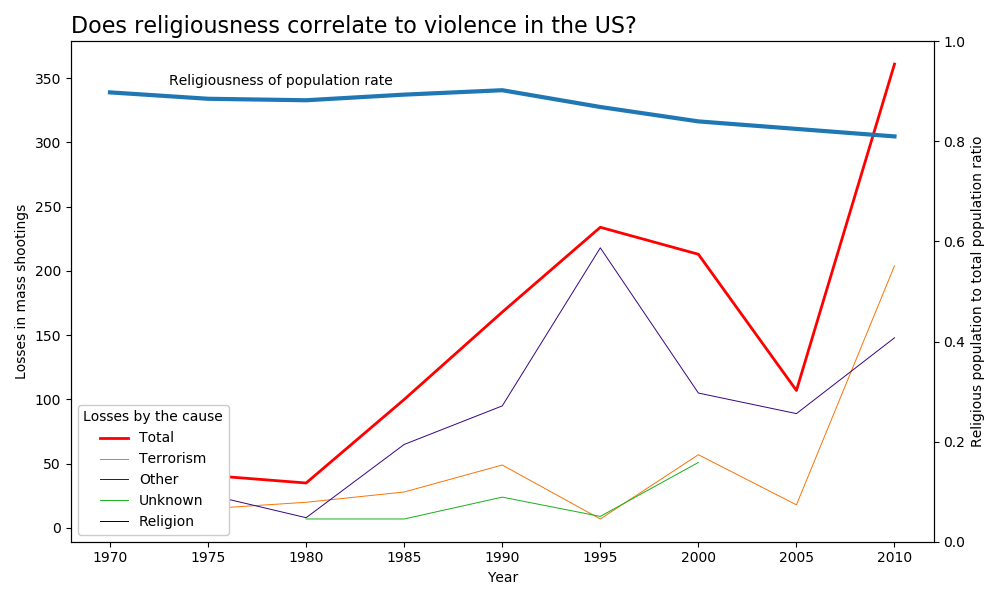

In [112]:
fig = plt.figure()
fig.set_size_inches(10, 6)
ax1 = fig.add_subplot(111)

line0, = ax1.plot(losses_total[:,0], losses_total[:,1], '-', linewidth=2, c='r')
line1, = ax1.plot(losses_by_terrorism[:,0], losses_by_terrorism[:,1], '-', linewidth=0.7, c='xkcd:orange')
line2, = ax1.plot(losses_by_other[:,0], losses_by_other[:,1], '-', linewidth=0.7, c='xkcd:indigo')
line3, = ax1.plot(losses_by_unknown[:,0], losses_by_unknown[:,1], '-', linewidth=0.7, c='xkcd:green')
line4, = ax1.plot(losses_by_religion[:,0], losses_by_religion[:,1], '-', linewidth=0.7, c='xkcd:black')

ax1.set_title('Does religiousness correlate to violence in the US?', loc='left', fontdict={'size': 16})
ax1.set_xlabel('Year')
ax1.set_ylabel('Losses in mass shootings', color='k')
ax1.tick_params('y', colors='k')
ax1.annotate('Religiousness of population rate',
            xy=(1975,345),
            xytext=(1973,345))

ax2 = ax1.twinx()
line5, = ax2.plot(religious_population[:,0], religious_population[:,1], '-', linewidth=3)
ax2.set_ylabel('Religious population to total population ratio', color='k')
ax2.tick_params('y', colors='k')
ax2.set_ylim([0., 1.])

legend1 = ax1.legend(['Total', 'Terrorism', 'Other', 'Unknown', 'Religion'], loc=3, title='Losses by the cause')
legend1.get_frame().set_alpha(1)

fig.tight_layout()
plt.show()

# Results
### As we can see, there is no clear correlation between mass violence (shootings) and religiosness, on the scale of US modern history (1970-2010)
This study is not definitive, and additional improvements can be made. For example, there could be a line of plot representing the ratio of total losses to total population, so we could estimate the relative losses as well.

## Cairo principles in the study
In this study I tried to implement four Cairo's principles of truth, beauty, function, and insight.
1. To make my research truthful, I kept the dates in 5-years span, as one of datasources was. While planning on plotting the casualities, I decided to kept losses split in 5 categories, which could or could not lead to some conclusion on correlation of religiousness of population and mass shootings. Furthermore, while labeling, I made titles and annotation as much specific as I could so to prevent insisting on somewhat rigged conclusion.
2. While this plot is not really an example of beautyful visualization, I tried to create as little of visual junk as possible (considering that beauty should not come before truthfulness). The most important lines were made thick, and I created a plot with separate y-axes, so it would be easier for the reader to compare trends and estimate correlation.
3. The main function of the plot is to visualize the correlation (or its absense, as it turned out) of religiousness of US population and losses of mass shootings. So to get it right, as I said earlier, I created lines on the plot with two y-axes, and provided a legend to determine, what cause motivated people the most to start a mass shooting and how it could be correlated with religiousness of the US population.
4. The insightfulness of the plot achieved by creating the most important lines different from the others. Though the research showed that there is neither positive nor negative clear correlation between religiousness and mass shootings, I believe that the negative result is still a result.